# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil



### Sample Size Calculation

In [2]:
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.06, 0.09)    
print(effect_size)


required_n = sms.NormalIndPower().solve_power( 
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1)

-0.11445118168989954


In [3]:
# Calculate sample size needed
required_n = ceil(required_n)                                             
print(required_n)

1199


### Collecting and preparing the data

In [4]:
# Load the tiktok_data.csv into a dataframe
df = pd.read_csv('data/tiktok_data.csv')
df.head()


,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [5]:
# Get the info of the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [6]:
# Make sure all the control group are seeing the star button and viceversa
df_control = df[(df['group'] == 'control')].copy() 
df_control = df_control[df['button'] != 'star'].copy() 

df_treat = df[df['group'] == 'treatment'].copy() 
df_treat = df_treat[df['button'] != 'heart'].copy() 

df_clean = pd.concat([df_control, df_treat], ignore_index=True) 
df.shape

C:\Users\yusse\AppData\Local\Temp/ipykernel_17220/2562020012.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_control = df_control[df['button'] != 'star'].copy()
C:\Users\yusse\AppData\Local\Temp/ipykernel_17220/2562020012.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treat = df_treat[df['button'] != 'heart'].copy()


(275781, 5)

In [8]:
# Check that no users have been sampled multiple times 

sess_count = df['user_id'].value_counts()
print(sess_count[sess_count > 1].count())

3453


In [9]:
# If there are users who have been sampled multiple times, remove them from the dataframe

drop = sess_count[sess_count > 1].index

df = df[~df['user_id'].isin(drop)]

#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [10]:
# Perform simple random sampling to split the data into control and treatment
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,134233,110
treatment,109,134423


In [11]:
# Create one table called ab_test that has both the cleaned control and treatment data
control_group = df[df['group'] == 'control'].sample(n=required_n, random_state=444)
treatment_group = df[df['group'] == 'treatment'].sample(n=required_n, random_state=444)

ab_test = pd.concat([control_group, treatment_group], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test


,user_id,timestamp,group,button,liked
0,775113,2017-01-05 3:50:46,control,heart,0
1,693666,2017-01-08 22:15:44,control,heart,0
2,841336,2017-01-08 3:03:58,control,heart,0
3,925455,2017-01-14 1:59:15,control,heart,0
4,802394,2017-01-09 9:33:28,control,heart,0
...,...,...,...,...,...
2393,820334,2017-01-08 7:38:16,treatment,star,0
2394,655705,2017-01-16 13:40:15,treatment,star,0
2395,688905,2017-01-21 3:51:06,treatment,star,0
2396,657370,2017-01-11 9:25:55,treatment,star,0


In [12]:
# Count the test groups to make sure that they're balanced 
ab_test['group'].value_counts()


control      1199
treatment    1199
Name: group, dtype: int64

### Analysis Visualization

In [14]:
# Find the like rate by group


# Find the Std. deviation of the proportion


# Find the Std. error of the proportion (std / sqrt(n))


# Calculate the final like rate

stats = ab_test.groupby('group')['liked'].agg(['std', 'mean', 'sem', 'sum', 'count'])
stats

,std,mean,sem,sum,count
group,,,,,
control,0.311045,0.108424,0.008983,130,1199
treatment,0.327154,0.121768,0.009448,146,1199


<AxesSubplot:xlabel='group', ylabel='liked'>

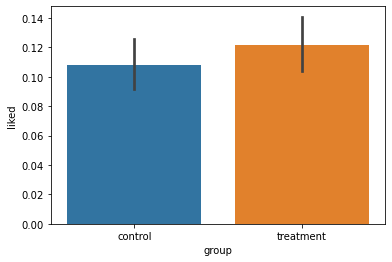

In [15]:
# Plot the like rate by group on a bar plot

sns.barplot(x=ab_test['group'], y=ab_test['liked'])

### Testing for Stat Sig

In [16]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups

# Get the number of samples in both groups

# Sum up the number of successes (likes) in both groups


In [122]:
# Find the z statistic and p value for proportions based on normal ztest


# Find the confidence intervals for each test group



In [18]:
# print z statistic

# print p-value

# print ci 95% for control group

# print ci 95% for treatment group


### Were the results signficant? 

### What would you advise the engineering team to do moving forward?